<h1>Data Analysis and Visualization</h1>
    


<ol>
<li>Read the data from <a href="https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv">https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv</a>
<li>Remove any data that is outside the NYC bounding box
<ul>
<li>NYC bounding box: westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
<li>See http://boundingbox.klokantech.com for info on bounding boxes
</ul>
<li>Calculate taxi trip duration and save in a new column "duration"
<li>Convert duration into a float
<li>Do some basic analysis (see below)
<li>Add a day of week column
<li>Add an hour of day column
<li>Do some analysis (see below)
<li>Divide the data into zones
<ul>
<li>write a function createZoneTable(zone_factor) that divides the bounding box into zones
<li>the idea is to create zone_factor * zone_factor zones
<li>e.g., if zone_factor is 20, you'll create 20*20 = 400 zones
<li>Divide the longitude (-73.7526 to -74.2635) into zone_factor (e.g., 20) sections
<li>Divide the latitude (40.4856 to 40.9596) into zone_factor (e.g., 20) sections
<li>Return a table (a list of lists) containing a zone id, and the coordinates of the zone
<li>(see e.g., below)
</ul>
<li>Write a function get_zone(lat,lon) that figures out the zone given a latitude and longitude
<li>Apply this function to the dataframe, first with pickup lats and longs; then with dropoff lats and longs
<li>This will give two new "pickup_zone" and "dropoff_zone" columns
<li>Do some analysis (see below)
<li>Using folium, draw a heatmap of the number of trips originating in each zone
<ul>
<li>Create a geojson object for all the zones 
<li>Create a df that contains zone numbers and the number of trips originating in each zone
<li>Use folium to create a heatmap
<li><b>OPTIONAL:</b> You'll notice that the bounding box is much larger than New York City. Try to remove every zone that has 0 originating trips from your map. (Hint: You can remove them from the geojson object)


<h2>Read the data</h2>


In [222]:
#Add necessary imports and functions to read the data
import pandas as pd
import numpy as np
import random

#Reading a sample of data

filename = "yellow_tripdata_2016-01.csv"
n = sum(1 for line in open(filename)) - 1 
s = 80000 
skip = sorted(random.sample(range(1,n+1),n-s)) 
df = pd.read_csv(filename, skiprows=skip)

<h2>Remove data outside the bounding box</h2>


In [223]:
def filter_by_latlong(df):
    #Filter by longitude for pickup
    df=df[(df["pickup_longitude"]>=westlimit) & (df["pickup_longitude"]<=eastlimit)]
    
    #Filter by longitude for dropoff
    df=df[(df["dropoff_longitude"]>=westlimit) & (df["dropoff_longitude"]<=eastlimit)]
    
    #Filter by latitude for pickup
    df=df[(df["pickup_latitude"]>=southlimit) & (df["pickup_latitude"]<=northlimit)]
    
    #Filter by latitude for dropoff
    df=df[(df["dropoff_latitude"]>=southlimit) & (df["dropoff_latitude"]<=northlimit)]
    
    return df

westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
df = filter_by_latlong(df)
    
    

<h2>Add a column for taxi trip duration</h2>
<li>strptime formats: http://pubs.opengroup.org/onlinepubs/009695399/functions/strptime.html

In [224]:
def convert_to_datetime(df):
    df["tpep_pickup_datetime"]=pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"]=pd.to_datetime(df["tpep_dropoff_datetime"])
    return df

df = convert_to_datetime(df) 

<h2>Convert duration column into a float (number of seconds)</h2>
<li><span style="color:blue">timedelta64(1, 's')</span> represents one second

In [225]:
import datetime

def time_delta_seconds(df):
    df['duration']=df["tpep_dropoff_datetime"]-df["tpep_pickup_datetime"]
    return df

def convert_to_seconds(duration):
    duration=duration.total_seconds()
    return duration

df = time_delta_seconds(df)
df['duration']=df['duration'].apply(convert_to_seconds)

<h2>Remove data where duration is greater than 10000 seconds</h2>

In [226]:
#df = df[df['duration']<=10000]
df=df[(df['duration']>=300) & (df['duration']<6000)]
df=df[(df['trip_distance']<1000) & (df['trip_distance']>0)]
#df.head(100)

<h2>Plot duration and compare with a gamma distribution</h2>

C:\Users\aksha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


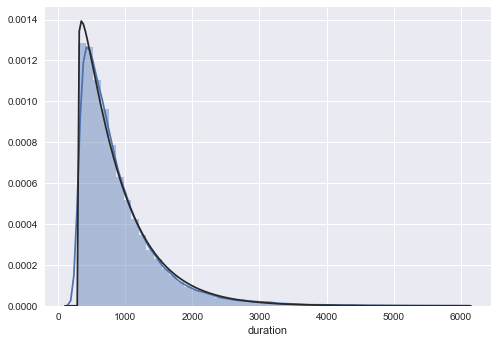

In [227]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from scipy import stats

sns.distplot(df['duration'],fit=stats.gamma)

<h2>Plot the scatter plot between trip_distance and duration</h2>

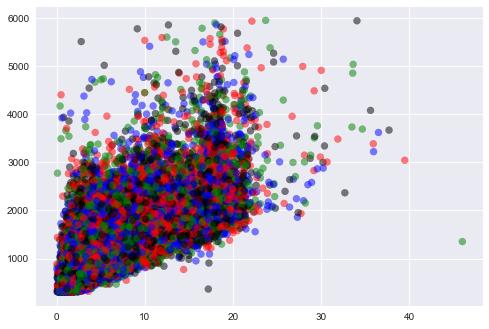

In [228]:
plt.scatter(df['trip_distance'],df['duration'],c=['red','blue','black','green'],alpha=0.5)
plt.show()

<h2>Create a column "day_of_week" that puts in an integer for the weekday</h2>
<li>Monday = 1, Sunday = 7
<li>Investigate here! https://docs.python.org/3/library/datetime.html
<li>Use tpep_pickup_datetime to get the weekday

In [230]:
def convert_weekday(pickup_datetime):
    pickup_datetime=pickup_datetime.isoweekday()
    return pickup_datetime

df['day_of_week'] = df['tpep_pickup_datetime'].apply(convert_weekday) 

<h2>Create time of day buckets using the hour part of tpep_pickup_datetime</h2>

In [231]:
def convert_hour(pickup_datetime):
    pickup_datetime=pickup_datetime.hour
    return pickup_datetime

df['pickup_hour'] = df['tpep_pickup_datetime'].apply(convert_hour)

<h2>Plot a bar graph that groups the data by day of week and then by time of day</h2>
<li>Do you notice any differences?</li>

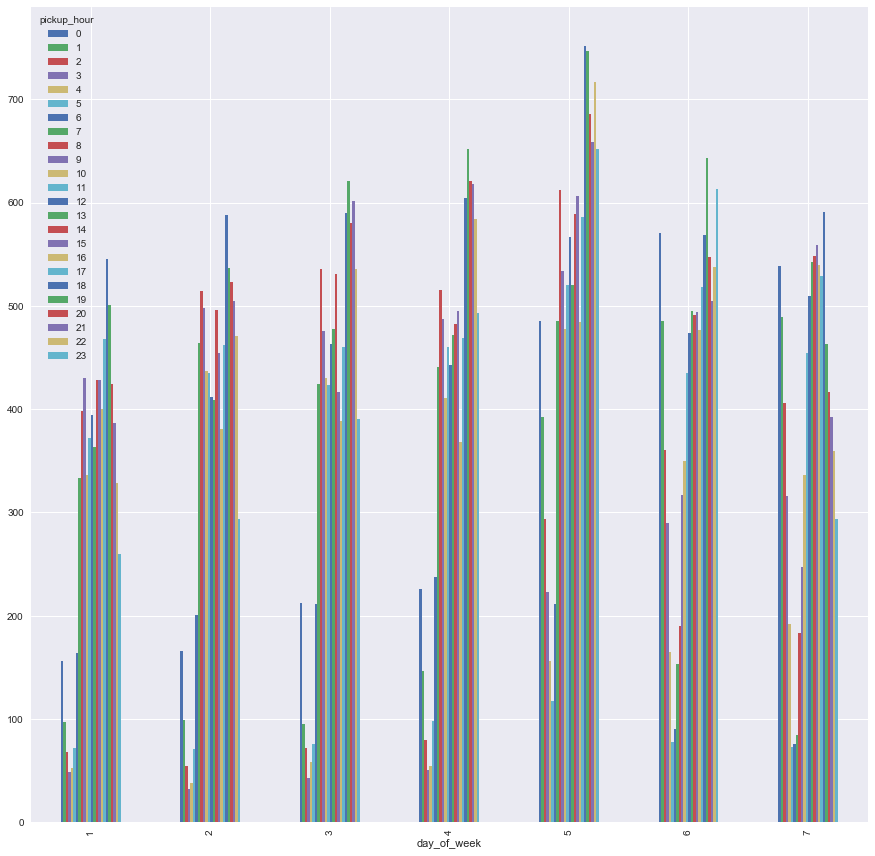

In [232]:
#group1=df.groupby(['pickup_hour','day_of_week'])

group1=df.groupby(['day_of_week','pickup_hour'])
group1.size().unstack().plot(kind='bar',figsize=(15,15))

<h2>Create zones</h2>

In [233]:
def createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596):
    zone_table = list()
    #Your code goes here
    long_factor=(eastlimit-westlimit)/zone_factor
    lat_factor=(northlimit-southlimit)/zone_factor
    wl=westlimit
    sl=southlimit
    count=0
    for i in range(zone_factor):
        zone_table_row_lat1=sl
        zone_table_row_lat2=sl+lat_factor
        wl=westlimit
        
        for j in range(zone_factor):
            zone_row=list()
            indexing=''
            coordinates=list()
            zone_table_row_long1=wl
            zone_table_row_long2=wl+long_factor
            
#             if zone_factor>=10:
#                 if count<10:
#                     indexing='00'+str(count)
#                 elif count>=10 and count<100:
#                     indexing='0'+str(count)
#                 else:
#                     indexing=str(count)
#             else:
#                 if count<10:
#                     indexing='0'+str(count)
#                 else:
            indexing=str(count)
            
            coord=list()
            coord.append(zone_table_row_long1)
            coord.append(zone_table_row_lat1)
            coordinates.append(coord)

            coord=list()
            coord.append(zone_table_row_long2)
            coord.append(zone_table_row_lat1)
            coordinates.append(coord)

            coord=list()
            coord.append(zone_table_row_long2)
            coord.append(zone_table_row_lat2)
            coordinates.append(coord)

            coord=list()
            coord.append(zone_table_row_long1)
            coord.append(zone_table_row_lat2)
            coordinates.append(coord)

            coord=list()
            coord.append(zone_table_row_long1)
            coord.append(zone_table_row_lat1)
            coordinates.append(coord)
            
            zone_row.append(indexing)
            zone_row.append(coordinates)
            zone_table.append(tuple(zone_row))
            count=count+1
            wl=zone_table_row_long2
            
        sl=zone_table_row_lat2
        
    return zone_table


Example of a zone table

[('00',
  [[40.4856, -74.2635],
   [40.4856, -74.21240999999999],
   [40.533, -74.21240999999999],
   [40.533, -74.2635],
   [40.4856, -74.2635]]),
 ('01',
  [[40.4856, -74.21240999999999],
   [40.4856, -74.16131999999999],
   [40.533, -74.16131999999999],
   [40.533, -74.21240999999999],
   [40.4856, -74.21240999999999]]),
 ('02',
  [[40.4856, -74.16131999999999],
   [40.4856, -74.11022999999999],
   [40.533, -74.11022999999999],
   [40.533, -74.16131999999999],
   [40.4856, -74.16131999999999]]),
 ('03',
  [[40.4856, -74.11022999999999],
   [40.4856, -74.05913999999999],
   [40.533, -74.05913999999999],
   [40.533, -74.11022999999999],
   [40.4856, -74.11022999999999]]),

In [234]:
def createGeoJsonObject(zone_table):
    zone_data_dict = dict()
    zone_data_dict['type'] = 'FeatureCollection'
    zone_data_dict_features = list()
    
    for i in zone_table:
        c_ord=list()
        c_ord.append(i[1])
        data_point={'geometry':{'coordinates':c_ord,'type':'Polygon'},
                    'properties':{'zone_id':i[0]},'type':'Feature'
        }
        zone_data_dict_features.append(data_point)
    
    zone_data_dict['features'] = zone_data_dict_features
    return zone_data_dict


Example of the 'features' list in the geojson object

{'features': [{'geometry': {'coordinates': [[[-74.2635, 40.4856],
      [-74.21240999999999, 40.4856],
      [-74.21240999999999, 40.533],
      [-74.2635, 40.533],
      [-74.2635, 40.4856]]],
    'type': 'Polygon'},
   'properties': {'zone_id': '00'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[-74.21240999999999, 40.4856],
      [-74.16131999999999, 40.4856],
      [-74.16131999999999, 40.533],
      [-74.21240999999999, 40.533],
      [-74.21240999999999, 40.4856]]],
    'type': 'Polygon'},
   'properties': {'zone_id': '01'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[-74.16131999999999, 40.4856],
      [-74.11022999999999, 40.4856],
      [-74.11022999999999, 40.533],
      [-74.16131999999999, 40.533],
      [-74.16131999999999, 40.4856]]],
    'type': 'Polygon'},
   'properties': {'zone_id': '02'},
   'type': 'Feature'},

<h3>Create the zone table for zone_factor = 20</h3>

In [235]:
zone_factor=30
zone_table = createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596)


<h2>Write a function that returns a zone number given a latitude and a longitude</h2>

<li>The function should return a string zone number
<li>For the example, <span style="color:blue">get_zone(40.65,-74.19)</span> the function should return "31"

In [236]:
def get_zone(lat,lon,zone_table):
    
    #Your code goes here
    zone=None
    for i in zone_table:
        if lat>=i[1][0][1] and lat<=i[1][2][1]:
            if lon>=i[1][0][0] and lon<=i[1][1][0]:
                zone=i[0]

    return zone

get_zone(40.65,-74.19,zone_table)

'304'

<h2>Create  pickup_zone and dropoff_zone columns for the dataframe</h2>
<li>This is a little tricky
<li>Pandas 'apply' function applies a function to each row in turn


<h4>apply</h4>

df.apply(foo)<br>
translates to<br>
foo(row1)<br>
foo(row2)<br>
foo(row3)<br>
i.e., the table row is the implicit argument of foo.
<p>
If we want to write our own foo, the argument to foo will be a dataframe row.<p>
From this row, we can extract the values we want and pass it to the explicit arguments of foo
<p>


In [ ]:
import pandas as pd
df_sample = pd.DataFrame([[1,5,7],[2,4,6],[3,9,2]],columns=['A','B','C'])

print(df_sample)
def foo(x,y):
    return x+y

df_sample['new_col'] = df_sample.apply(lambda x: foo(x['A'],x['B']),axis=1)
#axis = 1 means extract data from rows of the dataframe. by default, it extracts from columns. (Set axis to 0 and see what happens)

df_sample

df.head(1)

In [237]:
df['pickup_zone'] = df.apply(lambda x: get_zone(x['pickup_latitude'],x['pickup_longitude'],zone_table),axis=1 )
df['dropoff_zone'] = df.apply(lambda x: get_zone(x['dropoff_latitude'],x['dropoff_longitude'],zone_table),axis=1 )

<h2>Calculate the following</h2>
<li>Percentage of the total rides where the pickup zone is the same as the dropoff zone
<li>Zone with the highest pickups
<li>Zone with the highest dropoffs

In [238]:
print("% of Total Rides with same pickup and dropoff zone:",(len(df[df['pickup_zone']==df['dropoff_zone']])/len(df))*100)

temp_pickup=df.groupby('pickup_zone').size()

temp_pickup=temp_pickup.sort_values(ascending=False)
print("Zone with Highest Pickup",temp_pickup.index[0],temp_pickup[0])

temp_dropoff=df.groupby('dropoff_zone').size()

temp_dropoff=temp_dropoff.sort_values(ascending=False)
print("Zone with Highest Dropoff",temp_dropoff.index[0],temp_dropoff[0])



% of Total Rides with same pickup and dropoff zone: 7.484163722743331
Zone with Highest Pickup 526 8621
Zone with Highest Dropoff 526 7418


<h2>Groupby analysis</h2>
<li>Group data by the hour of the day and by the pickup zone
<li>Draw a figure of 24 plots that show the top 5 pickup zones at each hour


In [178]:
#Optional to Check - Plotting relative frequencies in a graph

# grouped=df.groupby(['pickup_hour','pickup_zone'])
# g1=pd.DataFrame(grouped.size())

# g1.rename(columns={0:'size'},inplace=True)
# g2=g1['size'].groupby(level=0,group_keys=False)
# g3=g2.apply(lambda x:x.sort_values(ascending=False).head(5))
# g3.unstack().plot(kind='bar',figsize=(15,15))



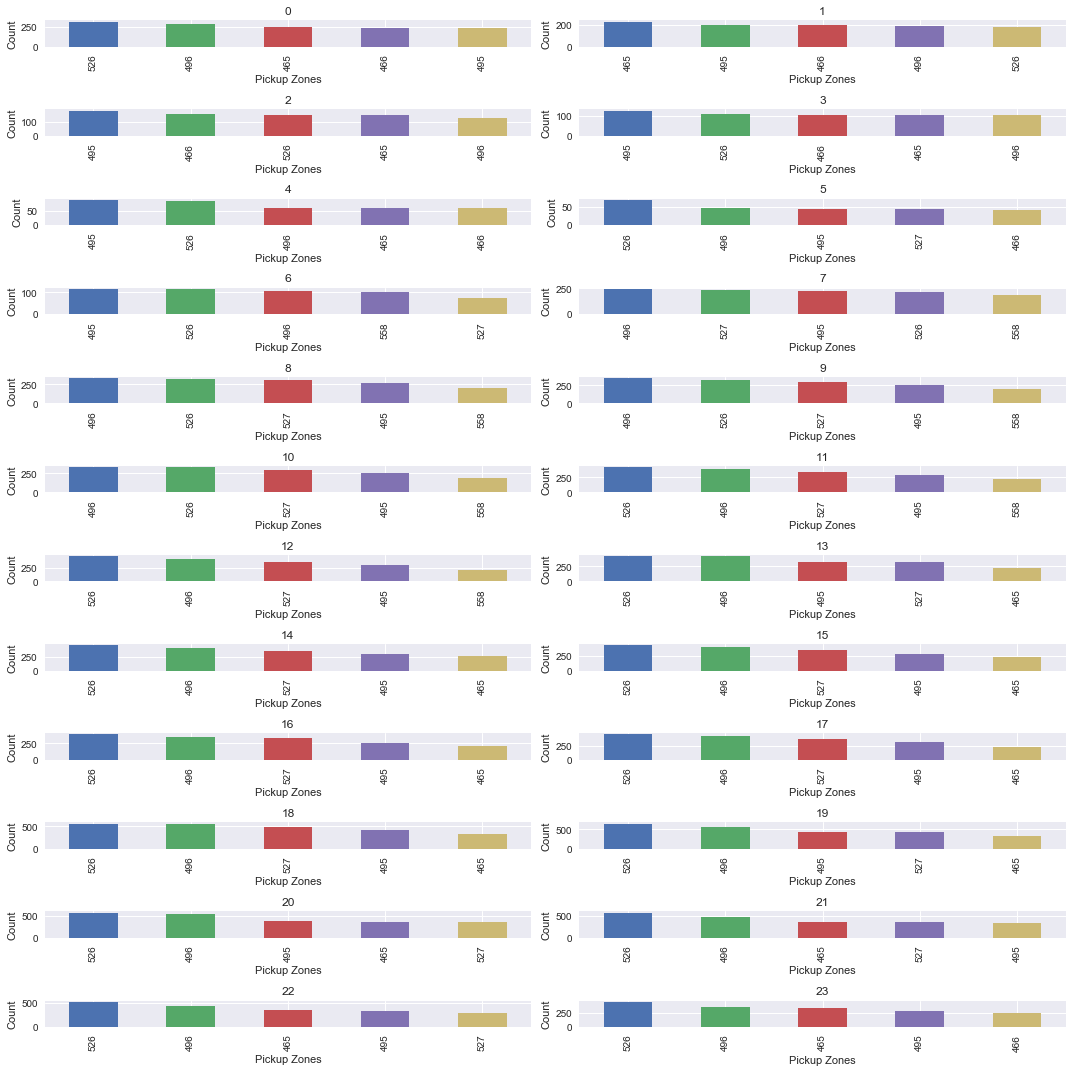

In [239]:
grouped=df.groupby(['pickup_zone','pickup_hour']).size().unstack()
COL_NUM = 2
ROW_NUM = 12
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))

for i,(pickup_hour,zone_count) in enumerate(grouped.items()):
    ax=axes[int(i/COL_NUM),i%COL_NUM]
    zone_count=zone_count.sort_values(ascending=False)[:5]
    zone_count.plot(kind='bar',ax=ax)
    ax.set_xlabel('Pickup Zones')
    ax.set_ylabel('Count')
    ax.set_title(pickup_hour)

plt.tight_layout()

<h2>Groupby analysis 2</h2>
<li>Group data by the weekday and the pickup zone
<li>Draw a figure of 7 plots that show the top 5 pickup zones on each day

In [177]:
#relative frequencies for comparative study

# grouped=df.groupby(['day_of_week','pickup_zone'])
# g1=pd.DataFrame(grouped.size())

# g1.rename(columns={0:'size'},inplace=True)
# g2=g1['size'].groupby(level=0,group_keys=False)
# g3=g2.apply(lambda x:x.sort_values(ascending=False).head(5))
# g3.unstack().plot(kind='bar',figsize=(15,15))


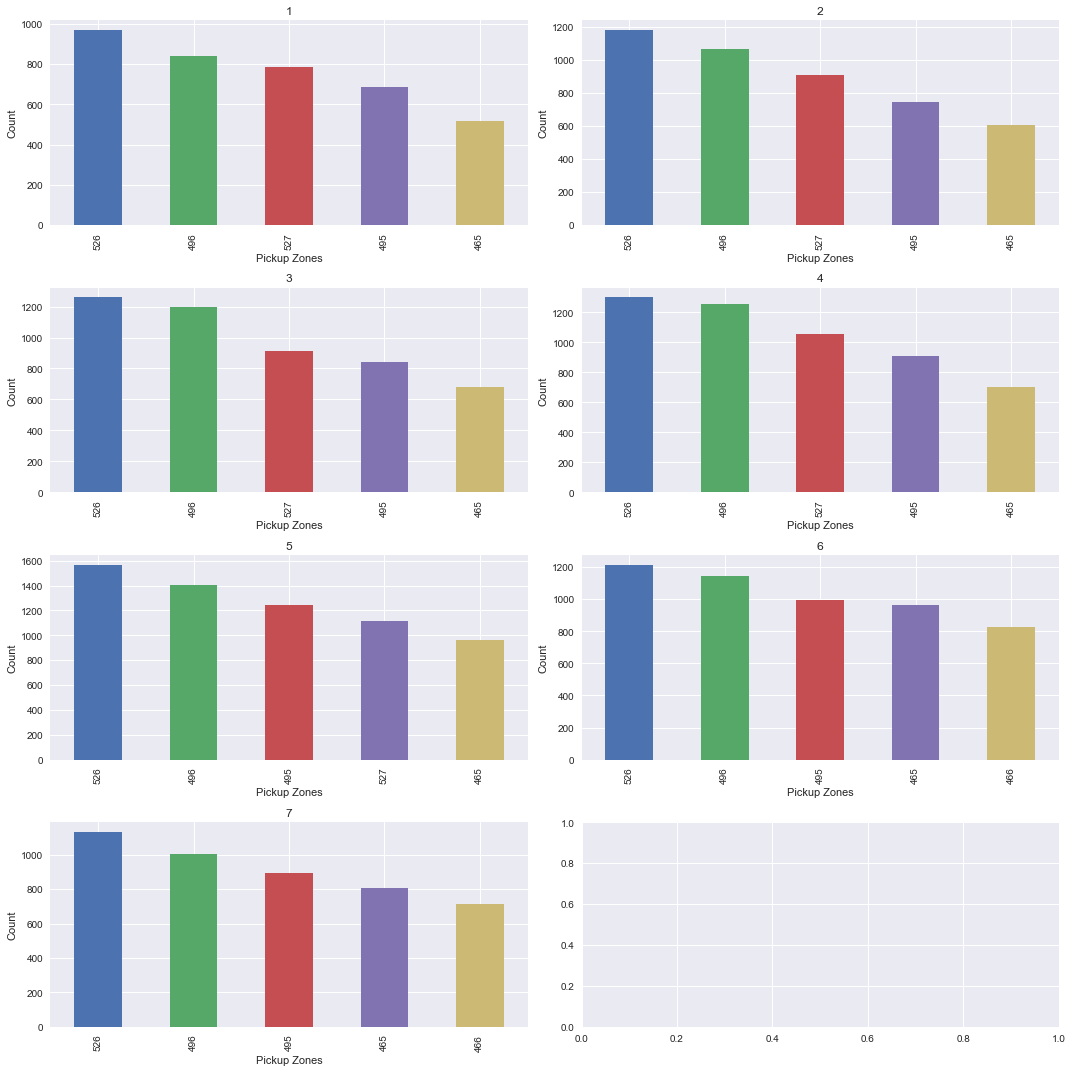

In [240]:
grouped=df.groupby(['pickup_zone','day_of_week']).size().unstack()
COL_NUM = 2
ROW_NUM = 4
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))

for i,(day_of_week,zone_count) in enumerate(grouped.items()):
    ax=axes[int(i/COL_NUM),i%COL_NUM]
    zone_count=zone_count.sort_values(ascending=False)[:5]
    zone_count.plot(kind='bar',ax=ax)
    ax.set_xlabel('Pickup Zones')
    ax.set_ylabel('Count')
    ax.set_title(day_of_week)

plt.tight_layout()


<h1>Most frequent morning pickups</h1>
<li>Identify the most frequent pickup zone between 8 am and 9 am on a weekday



In [241]:
#def finding_frequent():
df1=df[(df['pickup_hour']>=8) & (df['pickup_hour']<=9)]
df1=df1[(df['day_of_week']<=5)]
grouped=df1.groupby(['pickup_zone'])
grouped=pd.DataFrame(grouped.size())
grouped.rename(columns={0:'size'},inplace=True)
print(grouped.apply(lambda x:x.sort_values(ascending=False).head(1)))


             size
pickup_zone      
496           613


C:\Users\aksha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<h2>Mapping</h2>
<li>Draw a folium map using the polygon geojson object and the counts dataframe (see class example)

In [242]:
import folium
import json
import geojsonio

zone_factor=30
zone_table = createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596)
map_dict=createGeoJsonObject(zone_table)


df1=df.groupby('pickup_zone')
df1=pd.DataFrame(df1.size())
df1.rename(columns={0:'size'},inplace=True)
df1.reset_index(level=0,inplace=True)

In [243]:
m=folium.Map(location=[40.7589,-73.9851], zoom_start=12)

m.choropleth(geo_data=map_dict, data=df1 , columns=['pickup_zone','size'],
            key_on='feature.properties.zone_id',fill_color='RdYlGn',
            fill_opacity=0.7, line_opacity=0.8,legend_name="Distribution of Trips")
folium.LayerControl().add_to(m)

In [244]:
m